In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix
import os
import re

In [5]:
authors = {"MWS": "Mary Shelley", "HPL": "H. P. Lovecraft", "EAP": "Edgar Allan Poe"}
df = pd.DataFrame(pd.read_json("preprocessing_output/preprocessed_test_W.json").author)
df["author_short"] = df.author
df.author = df.author.apply(lambda x: authors[x])
for filename in os.listdir("results_output/"):
    fileparts = filename.split("_")
    method = fileparts[1]
    if "template" in method:
        continue
    preprocessing = ".".join(fileparts[2].split(".")[:-1])
    df[f"{method} with {preprocessing}"] = pd.read_json(f"results_output/results_{method}_{preprocessing}.json")
df


,author,author_short,lda with CSP,bayes with WSP,lda with CSPH1e-5,bayes with WSPH1e-4,lda with WL,bayes with WSPH1e-5,bayes with C,lda with C,...,bayes with CSPH1e-6,bayes with CSPH5e-5,bayes with WSPH5e-5,lda with CSPH1e-6,bayes with CSPH1e-5,lda with CSPH5e-5,lda with CSPH1e-4,bayes with WSPH5e-4,lda with WSPH5e-5,bayes with CSP
0,Edgar Allan Poe,EAP,EAP,EAP,EAP,EAP,EAP,EAP,EAP,EAP,...,EAP,EAP,EAP,EAP,EAP,EAP,EAP,EAP,EAP,EAP
1,Edgar Allan Poe,EAP,HPL,HPL,HPL,HPL,HPL,HPL,HPL,HPL,...,HPL,HPL,HPL,HPL,HPL,HPL,HPL,HPL,HPL,HPL
2,H. P. Lovecraft,HPL,MWS,MWS,MWS,MWS,MWS,MWS,MWS,MWS,...,MWS,MWS,MWS,MWS,MWS,MWS,MWS,MWS,MWS,MWS
3,Mary Shelley,MWS,HPL,HPL,HPL,HPL,HPL,HPL,HPL,HPL,...,HPL,HPL,HPL,HPL,HPL,HPL,HPL,HPL,HPL,HPL
4,H. P. Lovecraft,HPL,HPL,HPL,HPL,HPL,HPL,HPL,HPL,HPL,...,HPL,HPL,HPL,HPL,HPL,HPL,HPL,HPL,HPL,HPL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3911,Edgar Allan Poe,EAP,HPL,HPL,HPL,HPL,HPL,HPL,HPL,HPL,...,HPL,HPL,HPL,HPL,HPL,HPL,HPL,HPL,HPL,HPL
3912,Edgar Allan Poe,EAP,EAP,EAP,EAP,EAP,EAP,EAP,EAP,EAP,...,EAP,EAP,EAP,EAP,EAP,EAP,EAP,EAP,EAP,EAP
3913,Mary Shelley,MWS,HPL,HPL,HPL,HPL,HPL,HPL,HPL,HPL,...,HPL,HPL,HPL,HPL,HPL,HPL,HPL,HPL,HPL,HPL
3914,H. P. Lovecraft,HPL,MWS,MWS,MWS,MWS,MWS,MWS,MWS,MWS,...,MWS,MWS,MWS,MWS,MWS,MWS,MWS,MWS,MWS,MWS


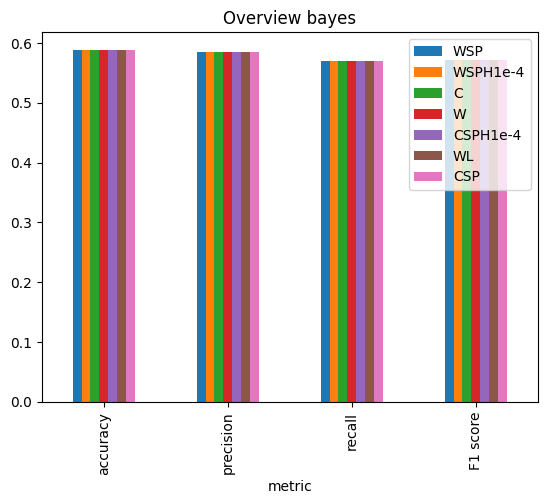

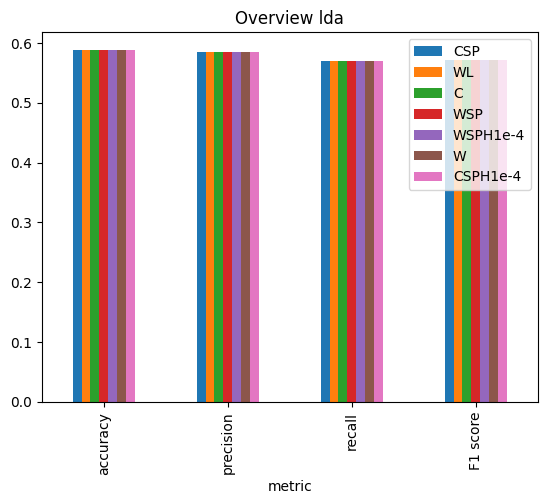

In [6]:
for method in ["bayes", "lda"]:
    method_df = df.loc[:, df.columns.str.contains(f"^(?:(?=.*\\b(?:author|{method}|author_short)\\b)(?:(?![56]).)*)$")]
    method_df = method_df.rename(columns=lambda x: re.sub(r".*\s(\S+)$", r"\1", x))
    score_df = method_df.iloc[: , 2:].apply(lambda x: [accuracy_score(x, method_df["author_short"]), precision_score(method_df["author_short"], x, average="macro"), recall_score(method_df["author_short"], x, average="macro"), f1_score(method_df["author_short"], x, average="macro")])
    score_df["metric"] = ["accuracy", "precision", "recall", "F1 score"]
    score_df.plot.bar("metric", title=f"Overview {method}")

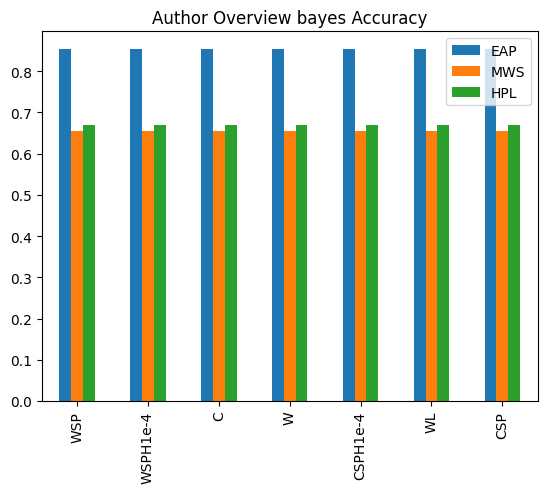

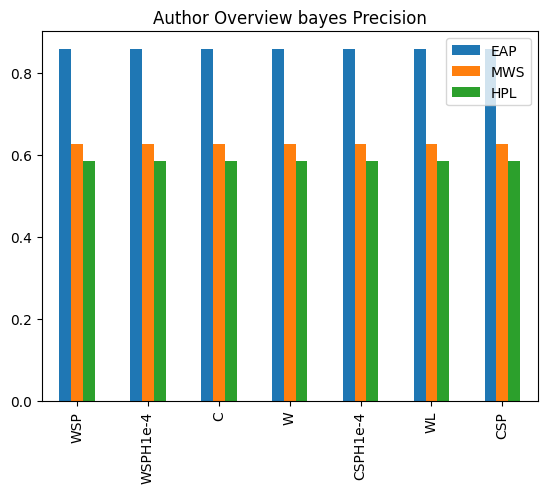

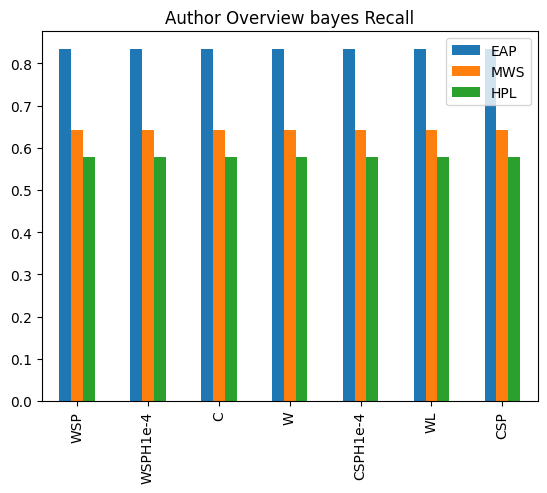

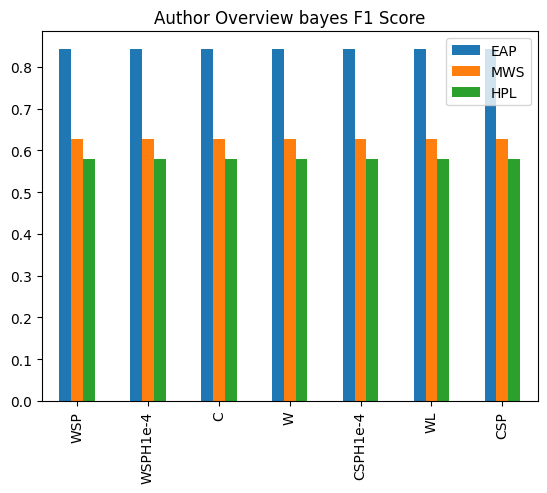

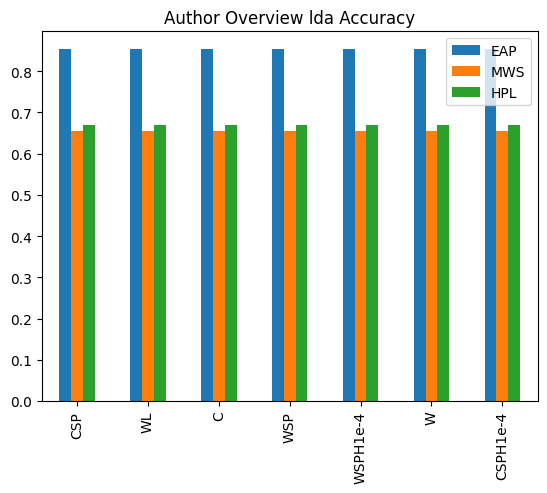

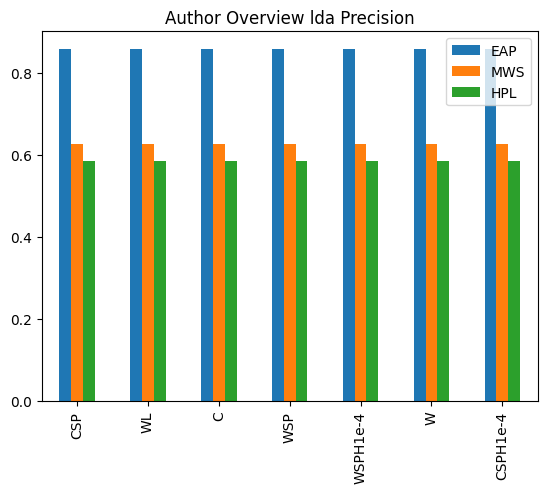

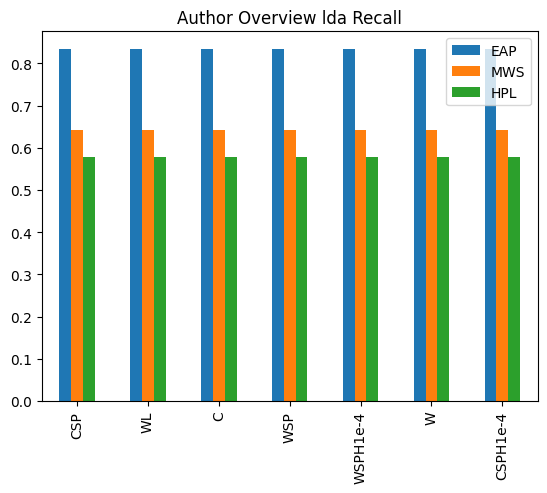

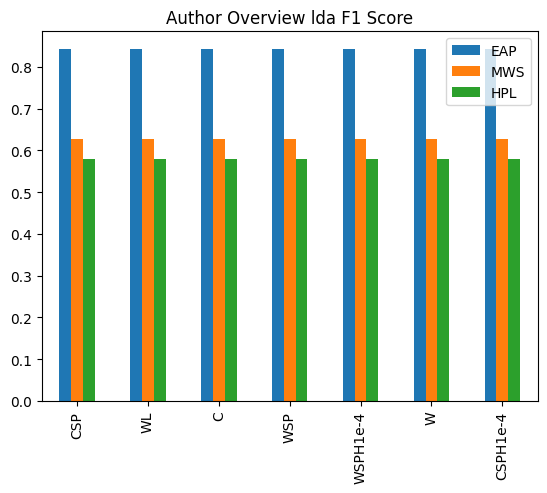

In [25]:
from collections import defaultdict

metrics = [("Accuracy", accuracy_score), ("Precision", lambda x, y: precision_score(x, y, average="macro")), ("Recall",
                                                                                                              lambda x, y: recall_score(x, y, average="macro")), ("F1 Score", lambda x, y: f1_score(x, y, average="macro"))]
for method in ["bayes", "lda"]:
    for (name, func) in metrics:
        score_df = {}
        method_df = df.loc[:, df.columns.str.contains(
            f"^(?:(?=.*\\b(?:author|{method}|author_short)\\b)(?:(?![56]).)*)$")]
        for author in ["EAP", "MWS", "HPL"]:
            author_df = pd.DataFrame(
                {"author": method_df["author"]})
            author_df = pd.concat([author_df, method_df.iloc[:, 1:].apply(
                lambda x: [1 if author == i else 0 for i in x])], axis=1)
            author_df = author_df.rename(columns=lambda x: re.sub(r".*\s(\S+)$", r"\1", x))
            score_df[author] = author_df.iloc[:, 2:].apply(
                lambda x: func(author_df["author_short"], x))
        score_df = pd.DataFrame(score_df)
        score_df.plot.bar(title=f"Author Overview {method} {name}")


/tmp/ipykernel_7374/3253275917.py:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  score_df = method_df.loc[:, method_df.columns.str.contains("(.*lda.*)|(.*author.*)")]
/tmp/ipykernel_7374/3253275917.py:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  score_df = method_df.loc[:, method_df.columns.str.contains("(.*lda.*)|(.*author.*)")]


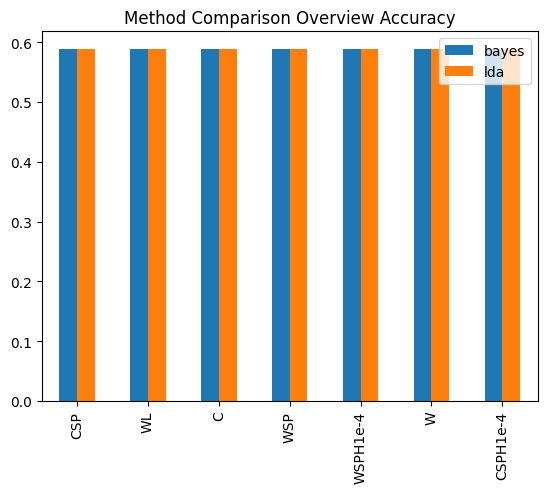

/tmp/ipykernel_7374/3253275917.py:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  score_df = method_df.loc[:, method_df.columns.str.contains("(.*lda.*)|(.*author.*)")]
/tmp/ipykernel_7374/3253275917.py:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  score_df = method_df.loc[:, method_df.columns.str.contains("(.*lda.*)|(.*author.*)")]


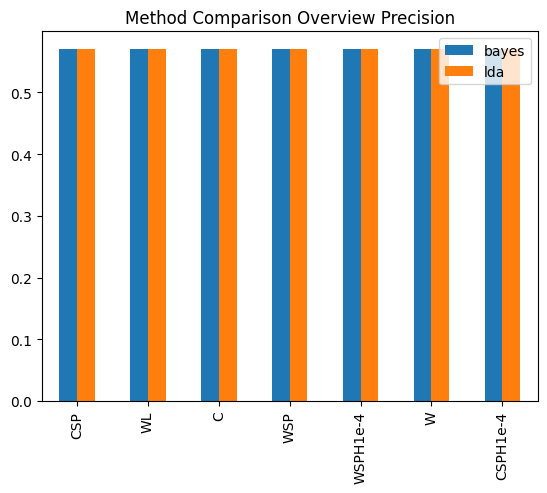

/tmp/ipykernel_7374/3253275917.py:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  score_df = method_df.loc[:, method_df.columns.str.contains("(.*lda.*)|(.*author.*)")]
/tmp/ipykernel_7374/3253275917.py:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  score_df = method_df.loc[:, method_df.columns.str.contains("(.*lda.*)|(.*author.*)")]


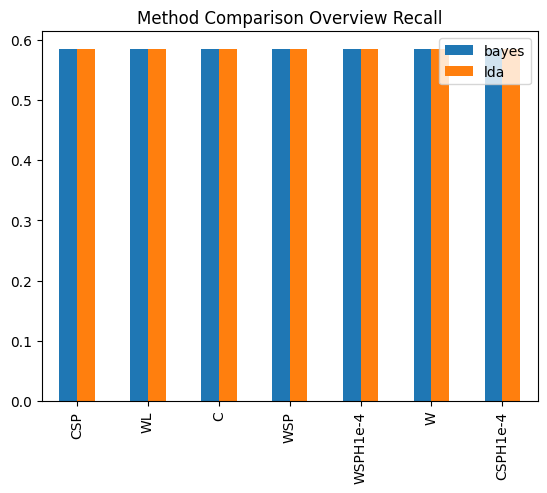

/tmp/ipykernel_7374/3253275917.py:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  score_df = method_df.loc[:, method_df.columns.str.contains("(.*lda.*)|(.*author.*)")]
/tmp/ipykernel_7374/3253275917.py:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  score_df = method_df.loc[:, method_df.columns.str.contains("(.*lda.*)|(.*author.*)")]


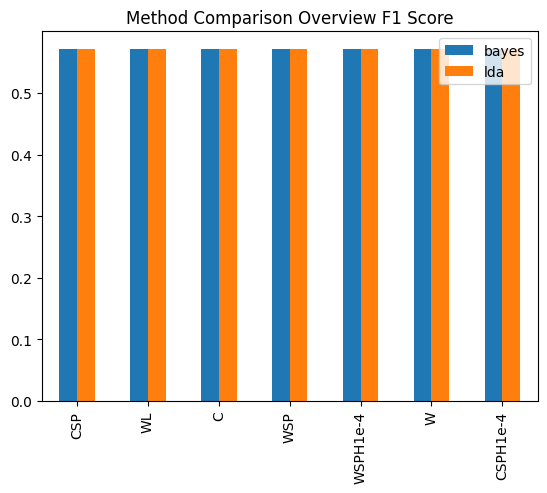

In [8]:
for (name, func) in metrics:
    preprocess_df = {}
    method_df = df.loc[:, df.columns.str.contains(f"^(?:(?=.*\\b(?:author|{method}|author_short)\\b)(?:(?![56]).)*)$")]
    for method in ["bayes", "lda"]:
        score_df = method_df.loc[:, method_df.columns.str.contains("(.*lda.*)|(.*author.*)")]
        score_df = score_df.rename(columns=lambda x: re.sub(r".*\s(\S+)$", r"\1", x))
        score_df = score_df.iloc[:, 2:].apply(lambda x: func(x, score_df["author_short"]))
        preprocess_df[method] = score_df
    preprocess_df = pd.DataFrame(preprocess_df)
    preprocess_df.plot.bar(title=f"Method Comparison Overview {name}")
    plt.legend(loc="upper right")
    plt.show()